## 序列模型

使用正弦函数和一些可加性噪声来生成序列数据，时间步为$1, 2,...,1000$

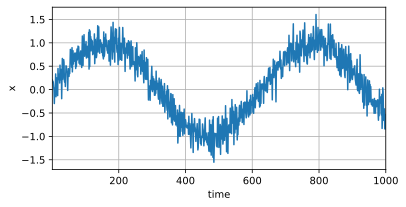

In [5]:
%matplotlib inline

import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6,3))

### 将数据映射为数据对$y_t = x_t$ 和 $\pmb x_t = [x_{t-\tau},...,x_{t-1}]$

In [18]:
tau = 4
features = torch.zeros((T-tau, tau))

for i in range(tau):
    features[:,i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1,1))

batch_size, n_train = 16, 600

train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

### 使用一个相当简单的结果：只是一个拥有两个全连接层的多层感知机


In [29]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10,1))
    net.apply(init_weights)
    return net
loss = nn.MSELoss()

### 训练模型

In [28]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 20, 0.01)

epoch 1, loss: 0.060537
epoch 2, loss: 0.053904
epoch 3, loss: 0.053464
epoch 4, loss: 0.052168
epoch 5, loss: 0.051792
epoch 6, loss: 0.053737
epoch 7, loss: 0.053008
epoch 8, loss: 0.055580
epoch 9, loss: 0.057531
epoch 10, loss: 0.055786
epoch 11, loss: 0.051140
epoch 12, loss: 0.051924
epoch 13, loss: 0.051724
epoch 14, loss: 0.050971
epoch 15, loss: 0.054399
epoch 16, loss: 0.053450
epoch 17, loss: 0.052060
epoch 18, loss: 0.051668
epoch 19, loss: 0.053703
epoch 20, loss: 0.052200


## 模型预测下一步时间步骤

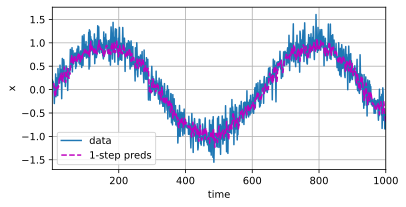

In [35]:
onestep_preds = net(features)
# d2l.plot(
#     [time, time[tau:]],
#     [x.detach().numpy(), onestep_preds.numpy()], 'time', 'x',
#     

d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

### 多步预测

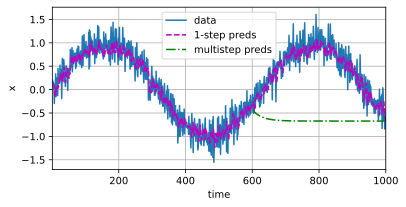

In [37]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

### 预测多步有问题

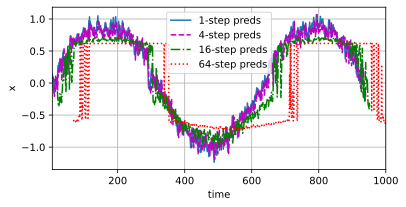

In [38]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))